In [1]:
USE_COLAB = False

if USE_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/data-valuation/
    !pip install -qr requirements.txt

## Download data

- [CIFAR-10.1](https://github.com/modestyachts/CIFAR-10.1)
- [CIFAR-C](https://github.com/hendrycks/robustness)

### Imports

In [4]:
import math
from collections import defaultdict
from importlib import reload
from pathlib import Path
import sys

import clip
import matplotlib
import numpy as np
import torch
from sklearn.decomposition import PCA
from torchvision.datasets import CIFAR10
from torchvision.models import ResNet18_Weights, resnet18
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams.update({"font.family": "serif"})

sys.path.append("../src")
import utils
from data import simple_DS, subset
import valuation

## Setup

### Load embeddings

In [5]:
# saved_embedding_path = Path("CHANGE_TO_EMBEDDING_DIRECTORY")
embedding_path = Path("../embeddings")

In [6]:
embedding_dict = {
    'cifar_domain': torch.load(embedding_path / 'clip_embedding_cifar_domain_shift.pt')['embeddings'],
    'cifar_brightness': torch.load(embedding_path / 'clip_embedding_cifar_c_brightness.pt'),
    'cifar_defocus': torch.load(embedding_path / 'clip_embedding_cifar_c_defocus_blur.pt'),
    'cifar_glass': torch.load(embedding_path / 'clip_embedding_cifar_c_glass_blur.pt'),
    'cifar_speckle_noise': torch.load(embedding_path / 'clip_embedding_cifar_c_speckle_noise.pt'),
    'cifar_motion_blur': torch.load(embedding_path / 'clip_embedding_cifar_c_motion_blur.pt'),
    'cifar_spatter': torch.load(embedding_path / 'clip_embedding_cifar_c_spatter.pt'),
    'cifar_shot_noise': torch.load(embedding_path / 'clip_embedding_cifar_c_shot_noise.pt'),
    'cifar_frost': torch.load(embedding_path / 'clip_embedding_cifar_c_frost.pt'),
    'cifar_impulse_noise': torch.load(embedding_path / 'clip_embedding_cifar_c_impulse_noise.pt'),
    'cifar_contrast': torch.load(embedding_path / 'clip_embedding_cifar_c_contrast.pt'),
    'cifar_gaussian_blur': torch.load(embedding_path / 'clip_embedding_cifar_c_gaussian_blur.pt'),
    'cifar_pixelate': torch.load(embedding_path / 'clip_embedding_cifar_c_pixelate.pt'),
    'cifar_zoom_blur': torch.load(embedding_path / 'clip_embedding_cifar_c_zoom_blur.pt'),
    'cifar_jpeg_compression': torch.load(embedding_path / 'clip_embedding_cifar_c_jpeg_compression.pt'),
    'cifar_elastic_transform': torch.load(embedding_path / 'clip_embedding_cifar_c_elastic_transform.pt'),
    'cifar_saturate': torch.load(embedding_path / 'clip_embedding_cifar_c_saturate.pt'),
    'cifar_gaussian_noise': torch.load(embedding_path / 'clip_embedding_cifar_c_gaussian_noise.pt'),
    'cifar': torch.load(embedding_path / 'clip_embedding_cifar_seller.pt')['images'],
    'fashion': torch.load(embedding_path / 'clip_embedding_fashion_seller.pt')['images'],
    'mnist': torch.load(embedding_path / 'clip_embedding_mnist_seller.pt')['images'],
    'pathmnist': torch.load(embedding_path / 'clip_embedding_medmnist_PathMNIST.pt')['embeddings'],
}

In [7]:
import torchvision.transforms as T
import torchvision.transforms.functional as F

Download CIFAR-10C data from [here](https://github.com/hendrycks/robustness)

In [30]:
# original clean version of cifar
cifar_data = CIFAR10(root='../../data/', train=False, download=True).data

# load distribution shifted version of cifar dataset
# cifar_shift_path = data_dir / "CIFAR-10.1/datasets"
# shift_data = np.load(cifar_shift_path / "cifar10.1_v4_data.npy")
# shift_targets = np.load(cifar_shift_path / "cifar10.1_v4_labels.npy")

# load corrupted version of cifar test set
cifar_noise_path = Path('../../data/CIFAR-10-C')
gauss_data = np.load(cifar_noise_path / 'gaussian_noise.npy')
impulse_data = np.load(cifar_noise_path / 'impulse_noise.npy')
jpeg_data = np.load(cifar_noise_path / 'jpeg_compression.npy')
blur_data = np.load(cifar_noise_path / 'motion_blur.npy')
contrast_data = np.load(cifar_noise_path / 'contrast.npy')
glass_data = np.load(cifar_noise_path / "glass_blur.npy")

sharpen = lambda x: F.adjust_sharpness(T.ToPILImage()(x), 2)

Files already downloaded and verified


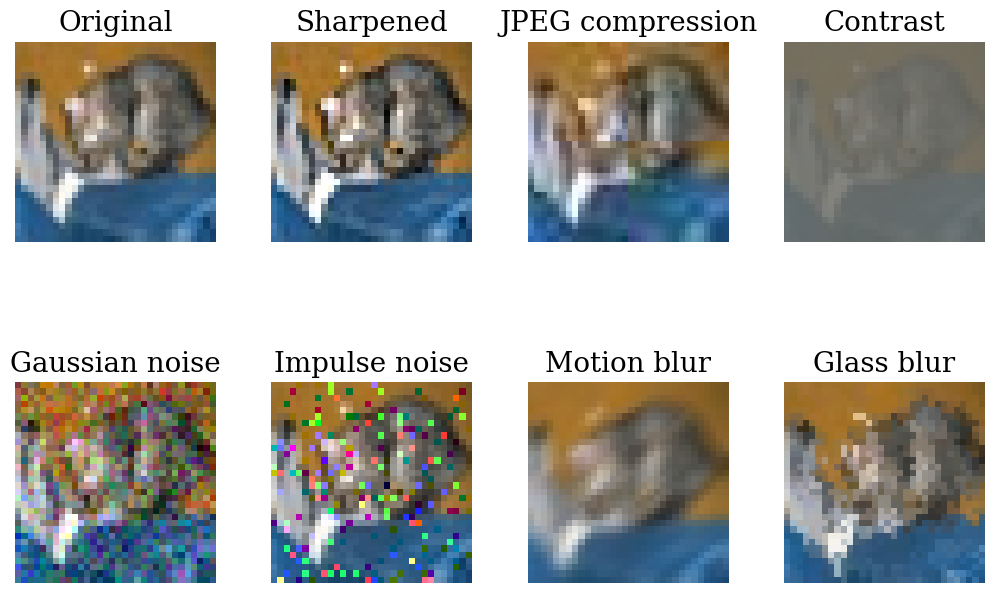

In [28]:
# image index
j = 0

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 7))
ax[0, 0].imshow(cifar_data[j])
ax[0, 1].imshow(sharpen(cifar_data[j]))
ax[0, 2].imshow(jpeg_data[j + 40000])
ax[0, 3].imshow(contrast_data[j + 40000])
ax[1, 0].imshow(gauss_data[j + 40000])
ax[1, 1].imshow(impulse_data[j + 40000])
ax[1, 2].imshow(blur_data[j + 40000])
ax[1, 3].imshow(glass_data[j + 40000])
ax[0, 0].set_title('Original', fontsize=20, pad=8)
ax[0, 1].set_title('Sharpened', fontsize=20, pad=8)
ax[0, 2].set_title('JPEG compression', fontsize=20, pad=8)
ax[0, 3].set_title('Contrast', fontsize=20, pad=8)
ax[1, 0].set_title('Gaussian noise', fontsize=20, pad=8)
ax[1, 1].set_title('Impulse noise', fontsize=20, pad=8)
ax[1, 2].set_title('Motion blur', fontsize=20, pad=8)
ax[1, 3].set_title('Glass blur', fontsize=20, pad=8)
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[0, 2].axis('off')
ax[0, 3].axis('off')
ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')
ax[1, 3].axis('off')

fig.tight_layout(h_pad=4, w_pad=4)
# plt.savefig('figures/cifar-images.png', bbox_inches='tight')

### Embed image data through pre-trained model

In [31]:
from torch.utils.data import DataLoader, TensorDataset

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
model.eval()

make_loader = lambda x, bs=32: DataLoader(
    TensorDataset(torch.tensor(x / 255).float().moveaxis(-1, 1)), batch_size=bs
)
embed_data = lambda x, mod: torch.cat(
    [mod(x[0].cuda()).detach().cpu() for x in tqdm(make_loader(x))]
)

embed_cifar_data = embed_data(cifar_data, model)
# embed_shift_data = embed_data(shift_data, model)
embed_jpeg_data = embed_data(jpeg_data, model)
embed_contrast_data = embed_data(contrast_data, model)
embed_gauss_data = embed_data(gauss_data, model)
embed_impulse_data = embed_data(impulse_data, model)
embed_blur_data = embed_data(blur_data, model)
embed_glass_data = embed_data(glass_data, model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/luchar/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

### Data valuations

In [42]:
def get_value(buyer_data, seller_data, relevance="cosine", diversity="volume"):
    values = valuation.get_value(buyer_data, seller_data, normalize=True)
    rel = values[relevance]
    div = values[diversity]
    return rel, div


# Change number of buyer components to project to calculate diversity and relevance
n_components = 10

buyer_rel, buyer_div = get_value(embed_cifar_data[:100], embed_cifar_data[100:])
# seller_rel, seller_div = get_value(buyer_pca, embed_seller_data)
# shift_rel, shift_div = get_value(buyer_pca, embed_shift_data)


# CIFAR-C dataset has 5 noise levels for each corruption
jpeg_valuations = defaultdict(list)
contrast_valuations = defaultdict(list)
gauss_valuations = defaultdict(list)
impulse_valuations = defaultdict(list)
blur_valuations = defaultdict(list)
glass_valuations = defaultdict(list)

for noise_level in range(5):
    s = slice(noise_level * 10000, (noise_level + 1) * 10000)

    jpeg_rel, jpeg_div =  get_value(embed_cifar_data[:100], embed_jpeg_data[s])
    jpeg_valuations["relevance"].append(jpeg_rel)
    jpeg_valuations["diversity"].append(jpeg_div)
    
    contrast_rel, contrast_div =  get_value(embed_cifar_data[:100], embed_contrast_data[s])
    contrast_valuations["relevance"].append(contrast_rel)
    contrast_valuations["diversity"].append(contrast_div)
    
    gauss_rel, gauss_div =  get_value(embed_cifar_data[:100], embed_gauss_data[s])
    gauss_valuations["relevance"].append(gauss_rel)
    gauss_valuations["diversity"].append(gauss_div)

    impulse_rel, impulse_div =  get_value(embed_cifar_data[:100], embed_impulse_data[s])
    impulse_valuations["relevance"].append(impulse_rel)
    impulse_valuations["diversity"].append(impulse_div)

    blur_rel, blur_div =  get_value(embed_cifar_data[:100], embed_blur_data[s])
    blur_valuations["relevance"].append(blur_rel)
    blur_valuations["diversity"].append(blur_div)
    
    glass_rel, glass_div =  get_value(embed_cifar_data[:100], embed_glass_data[s])
    glass_valuations["relevance"].append(glass_rel)
    glass_valuations["diversity"].append(glass_div)

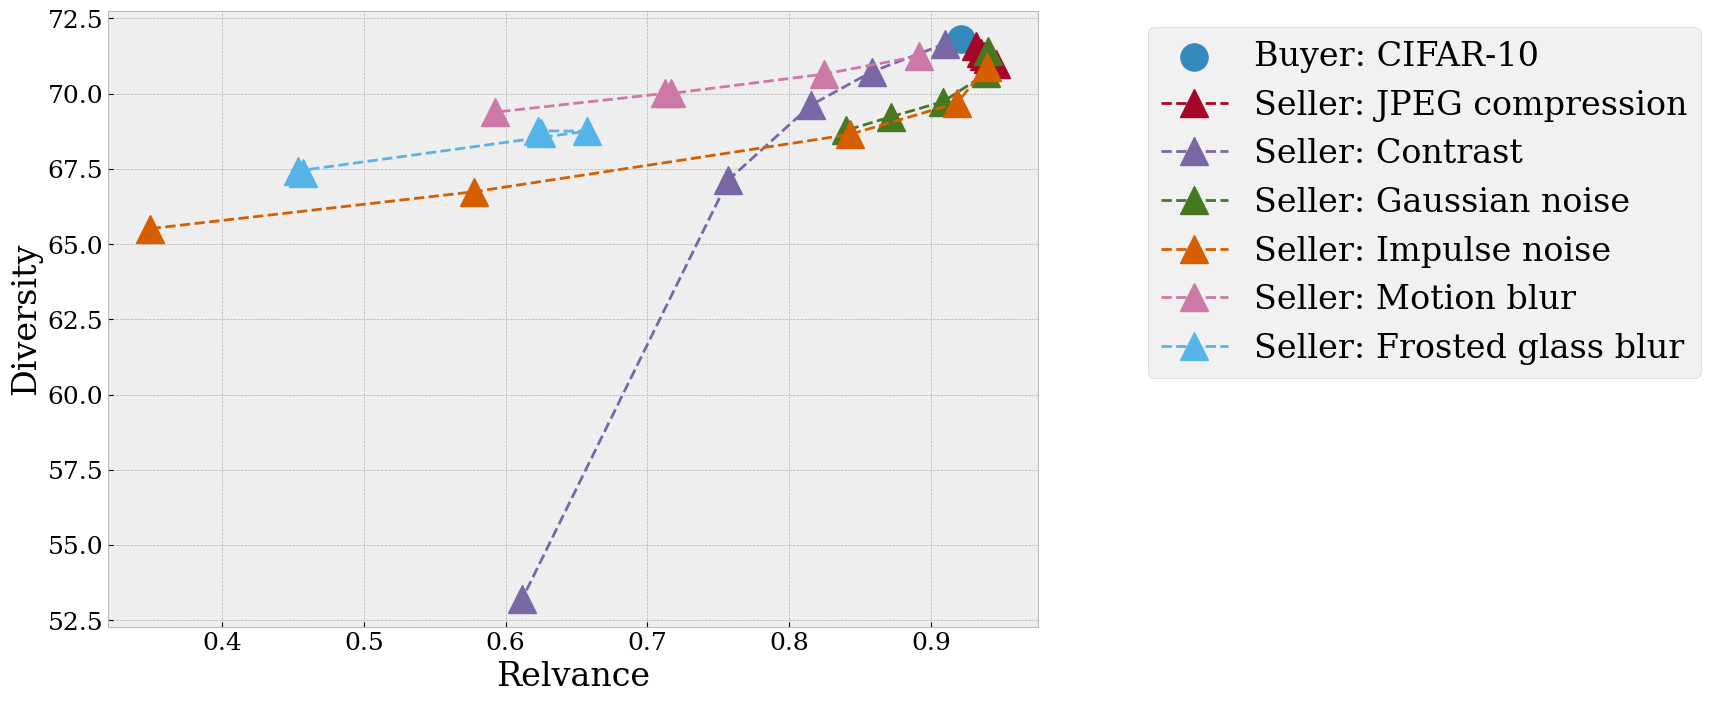

In [43]:
s = 400
plt.figure(figsize=(12, 8))
plt.scatter(buyer_rel, buyer_div, s=s, marker="o", label="Buyer: CIFAR-10")
# plt.scatter(seller_rel, seller_div, s=s, marker="s", label="Seller: CIFAR-10")
# plt.scatter(shift_rel, shift_div, s=s, marker="D", label="Seller: CIFAR-10.1")
plt.plot(
    jpeg_valuations["relevance"],
    jpeg_valuations["diversity"],
    "^--",
    c="C1",
    markersize=20,
    label=f"Seller: JPEG compression",
)
plt.plot(
    contrast_valuations["relevance"],
    contrast_valuations["diversity"],
    "^--",
    c="C2",
    markersize=20,
    label=f"Seller: Contrast",
)
plt.plot(
    gauss_valuations["relevance"],
    gauss_valuations["diversity"],
    "^--",
    c="C3",
    markersize=20,
    label=f"Seller: Gaussian noise",
)
plt.plot(
    impulse_valuations["relevance"],
    impulse_valuations["diversity"],
    "^--",
    c="C4",
    markersize=20,
    label=f"Seller: Impulse noise",
)
plt.plot(
    blur_valuations["relevance"],
    blur_valuations["diversity"],
    "^--",
    c="C5",
    markersize=20,
    label=f"Seller: Motion blur",
)
plt.plot(
    glass_valuations["relevance"],
    glass_valuations["diversity"],
    "^--",
    c="C6",
    markersize=20,
    label=f"Seller: Frosted glass blur",
)

plt.xlabel("Relvance", fontsize=24)
plt.ylabel("Diversity", fontsize=24)
# plt.xlim(0, 1.1)
# plt.title(fontsize=20, pad=12)
plt.tick_params(labelsize=18)
plt.legend(fontsize=24, bbox_to_anchor=(1.1, 1))
# plt.savefig("figures/cifar-noise.png", bbox_inches="tight")